In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
# import mosek
import pickle
from pandas.tseries.offsets import BMonthEnd
from time import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PerformanceMetrics import *

import seaborn as sns

In [2]:
ff_factors = pd.read_csv('data/F-F_Research_Data_Factors_Monthly.csv',index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index)

ff_factors = ff_factors.reset_index()
cols = list(ff_factors.columns)
cols[0]='Date'
ff_factors.columns = cols

ff_factors.tail(5)

,Date,Mkt-RF,SMB,HML,RF
1150,2022-05-31,-0.0034,-0.0185,0.0841,0.0003
1151,2022-06-30,-0.0843,0.0209,-0.0597,0.0006
1152,2022-07-29,0.0957,0.0281,-0.0410,0.0008
1153,2022-08-31,-0.0378,0.0139,0.0031,0.0019
1154,2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [3]:
weights_benchmark = pd.read_csv('./data/weights_benchmark.csv')
weights_benchmark.columns = ['Date', 'permno', 'weights_bench']
weights_benchmark['Date'] = pd.to_datetime( weights_benchmark['Date'], format='%Y%m') + BMonthEnd()
weights_benchmark

,Date,permno,weights_bench
0,1926-01-29,10401,0.048519
1,1926-01-29,11850,0.034119
2,1926-01-29,12060,0.029779
3,1926-01-29,14541,0.026572
4,1926-01-29,15069,0.024792
...,...,...,...
577491,2022-03-31,76082,0.000469
577492,2022-03-31,89470,0.000469
577493,2022-03-31,45911,0.000469
577494,2022-03-31,23473,0.000468


In [4]:
n = 2000

# Get the excess returns data
idx = pd.read_csv('data/TOP{}_universe.csv'.format(n), parse_dates=[0])
idx = idx[idx['date'] >= '1970-01-01'].reset_index(drop = True)

returndata = pd.read_csv('data/crspmsf.csv', index_col = 0)[['date', 'permno', 'ret']]
returndata['date'] = pd.to_datetime( returndata['date'] )
returndata['permno'] = returndata['permno'].astype(int)
returndata = returndata[returndata['date'] >= '1970-01-01'].reset_index(drop = True)
returndata['date'] = pd.to_datetime(returndata['date']) - pd.tseries.offsets.MonthBegin() + pd.tseries.offsets.BMonthEnd()

betaData = pd.read_csv('data/return_pf_excess_ret_beta.csv', index_col = 0)[['date','permno' ,'beta_30']]
betaData['date'] = pd.to_datetime(betaData['date'],format='%Y%m') + BMonthEnd()
betaData = betaData[betaData['date'] >= '1970-01-01'].reset_index(drop = True)


with open('data/exalpha_beta_30.pkl', 'rb') as f:
    data = pickle.load(f)

print(idx.head())
print(data.head())
print(returndata.head())

universe = pd.read_csv(f'data/TOP2000_universe.csv',parse_dates=[0],index_col=0)
universe500 = pd.read_csv(f'data/TOP500_universe.csv',parse_dates=[0],index_col=0)
ff_loadings = pd.read_pickle('data/ffloadings_halflife36_TOP2000.pkl')
ff_cov_df = pd.read_pickle(f'data/ff_cov_halflife{36}.pkl')
spec_est = pd.read_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl')

def risk_cov(date,annualize=12):
    ff_cols = ['Mkt-RF','HML','SMB']
    betas = ff_loadings.loc[date,(universe.loc[date],slice(None))].unstack()[ff_cols].dropna(axis=0)
    ff_cov = ff_cov_df.loc[date].loc[ff_cols,ff_cols]
    spec_cov = spec_est.loc[date]
    
    idx = spec_cov.index.intersection(betas.index)
    spec_cov = spec_cov.reindex(idx)
    betas = betas.reindex(idx)

    cov = betas@ff_cov@betas.T + np.diag(spec_cov)
    return cov * np.sqrt(annualize)

        date      0      1      2      3      4      5      6      7      8  \
0 1970-01-30  12490  10401  12079  11754  11850  14322  27983  14736  12060   
1 1970-02-27  12490  10401  12079  11754  11850  14322  14736  27983  12060   
2 1970-03-31  12490  10401  12079  11850  11754  14322  14736  27983  12060   
3 1970-04-30  12490  10401  12079  11850  11754  14322  14736  27983  12060   
4 1970-05-29  12490  10401  12079  11850  11754  14322  14736  27983  12060   

   ...   1990   1991   1992   1993   1994   1995   1996   1997   1998   1999  
0  ...  48661  31480  41304  40256  48573  48899  45460  35246  44177  37444  
1  ...  43174  46711  34331  49998  35051  41304  43406  46519  45823  38340  
2  ...  33582  46500  35641  49429  37612  36644  36695  33830  44943  41574  
3  ...  47618  31106  46498  44804  32459  47407  31819  41574  37989  47685  
4  ...  31595  32440  31106  14197  42876  44513  32133  39132  48848  43537  

[5 rows x 2001 columns]
date        permno
1970-01

In [5]:
def FactorMimickingPortOpt_MV(alpha, beta, gamma, V):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''
    n = V.shape[0]
    x = cp.Variable(n)
    
    obj = cp.Maximize(x.T@alpha - gamma/2*cp.quad_form(x,V))
    constraints = [x.T@beta == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    return x.value, prob.value

def FactorMimickingPortOpt_SR(alpha, beta, V, indiv_alpha_contrib=0.1):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''

    # try:

    n = V.shape[0]
    z = cp.Variable(n)
    kappa = cp.Variable(1)

    alpha = alpha.reshape(alpha.shape[0])
    V = cp.atoms.affine.wraps.psd_wrap(V)

    obj = cp.Minimize(cp.quad_form(z,V))

    # ORIGINAL CONSTRAINT: SUM(X)==1 CONSTRAINT IS NOT APPLICABLE
    # constraints = [z.T@beta == 0, z.T@alpha == 1, np.ones(n)@z-kappa==0, kappa>=0, ]
    # FIRST UPDATED CONSTRAINT: WORKS BUT CAN LEAD TO CONCENTRATED PORTFOLIOS
    # constraints = [z.T@beta == 0, z.T@alpha == 1 ]
    # NEW UPDATED CONSTRAINT: LIMIT EACH POSITION'S ALPHA CONTRIBUTION TO A CONSTANT VALUE
    constraints = [z.T@beta == 0, z.T@alpha == 1, cp.multiply(z,alpha) <= indiv_alpha_contrib]
    prob = cp.Problem(obj, constraints)
    val = prob.solve(solver=None,verbose=False)
    if z.value is None:
        raise Exception()
    #return z.value/ kappa.value 
    return z.value

def InvestorPortOpt(mu, V, x_b, gamma):
    n = V.shape[0]
    x = cp.Variable(n)
    z = cp.Variable(n)
    y = cp.Variable(n)
    leverage_constraint = 0.2
    active_size = 0.02

    obj = cp.Maximize((x-x_b).T@mu - (gamma/2)*cp.quad_form((x-x_b),V)) 
    constraints = [ z<=x, z<=0, -z.T@np.ones(n)<=leverage_constraint ]
    constraints.extend([cp.sum(x) == 1])
    
    #constraints.extend( [ y>=x, y>=0, y.T@np.ones(n)==1 ] )
    
    constraints.extend([cp.abs(x[i] - x_b[i]) <=active_size for i in range(n)]) 
    #constraints.extend([(x_b - x[i]) <=active_size for i in range(n)]) 
    
    prob = cp.Problem(obj, constraints)
    
    #prob = cp.Problem(obj)
    prob.solve()#solver=cp.GUROBI)
    
    return x.value, prob.value


In [6]:
targetVol = 0.05
fullData = dict()
fullDataBenchmark = dict()
noConv = 0
gamma = 0.5
#for i in range(1, idx['date'].shape[0]):
#for i in tqdm(list(range(36,120))):
for i in tqdm(list(range(36, idx.shape[0] - 1))):
    start = time()

    #Loop through the dates
    specificDate = idx['date'][i]
    returnsDate = idx['date'][i+1]
    
    #Get the benchmarke permno and weights
    benchmark = weights_benchmark.loc[weights_benchmark['Date'] == specificDate, :]

    #Get the covariance matrix
    V = risk_cov(specificDate)

    #For that specific date, get the permno of the investable stocks 
    specificPermno = idx[idx['date'] == specificDate].iloc[:, 1:].T
    specificPermno.columns = ['permno']

    #Get the alphas for that specific date
    alphas = pd.DataFrame( data[specificDate]).reset_index()
    alphas['beta_30_exalpha'] = (alphas['beta_30_exalpha'] - alphas['beta_30_exalpha'].mean())/alphas['beta_30_exalpha'].std()

    #Get the betas for that specific date
    betas = betaData[betaData['date'] == specificDate]

    #merge the alphas of that date with the permno of the investable stocks
    alphas_permno = pd.merge(alphas, specificPermno, how = 'inner', on = 'permno')
    benchmark = pd.merge(alphas, benchmark, how = 'inner', on = 'permno')

    #merge the betas of that date with the permno of the investable stocks
    betas_permno = pd.merge(betas, specificPermno, how = 'inner', on = 'permno')

    #Merge the returns of that date with the permno of the investable stocks
    returns_permno = pd.merge(returndata[returndata['date'] == returnsDate].dropna(), specificPermno, how = 'inner', on = 'permno')
    benchmark = pd.merge(returndata[returndata['date'] == returnsDate].dropna(), benchmark, how = 'inner', on = 'permno')
    
    #Merge, alphas, betas and returns 
    investableStocks = pd.merge(alphas_permno, betas_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, returns_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, universe500.loc[specificDate].rename('permno').to_frame(), on = 'permno', how = 'inner')
    investableStocks, V_factorPort = investableStocks.set_index('permno').align(V, join='inner',axis=0)
    #factor mimicking Variance
    V_factorPort = V_factorPort.reindex(columns = V_factorPort.index)
    
    #V for investor portfolio
    benchmark, V_investor = benchmark.set_index('permno').align(V,join='inner',axis=0)
    V_investor = V_investor.reindex(columns = V_investor.index)
    



    # #the shape of investable stocks is not matching with the shape of V.
    # finalPermno = ''
    # if V.shape[0] < investableStocks.shape[0]:
    #     print('V smaller')
    #     finalPermno = list( V.index)
    #     invest_copy = investableStocks.set_index('permno')
    #     investableStocks = invest_copy.loc[finalPermno, :]
    # else:
    #     finalPermno = list( investableStocks.permno)
    #     V = V.loc[finalPermno, finalPermno]

    assert investableStocks.isna().sum().sum() == 0
    assert V_factorPort.shape[0] == investableStocks.shape[0], 'Shape of alphas and V must match'

    shape = (investableStocks.shape[0], 1)
    alpha = investableStocks['beta_30_exalpha'].values.reshape(shape)
    beta = investableStocks['beta_30'].values.reshape(shape)
    V_np = V_factorPort.values
    
    shape_investor = (benchmark.shape[0], 1)
    alphas_investor = benchmark['beta_30_exalpha'].values.reshape(shape_investor)
    x_b = benchmark['weights_bench'].values
    x_b /= x_b.sum()
    V_np_inv = V_investor.values

    
    ### Factor mimicking portfolio
    w = FactorMimickingPortOpt_SR(alpha, beta, V_np)
    print('sum of weights', w.sum())
    portfolioVol = np.sqrt(w.T @ V_np @ w)
    scaledW = (targetVol/portfolioVol) * w
    investableStocks['w'] = w
    investableStocks['scaled_w'] = scaledW

    #Create one column with equally weighted weights and equally weighted weights scaled
    #Sort values
    investableStocks = investableStocks.sort_values(by = 'beta_30')

    #get top and bottom percentiles
    perc10 = investableStocks.shape[0]//10
    perc90 = investableStocks.shape[0] - perc10

    #Define the weight of top and bottom 10%
    investableStocks['wEq'] = 0
    investableStocks.iloc[0:perc10, -1] = (1/perc10)
    investableStocks.iloc[perc90:, -1] = 1/(investableStocks.shape[0] - perc90)

    #Define winner and losser and get the betas
    winner = investableStocks.iloc[0:perc10, :]
    losser = investableStocks.iloc[perc90:, :]

    betaWinner = winner.beta_30.T @  winner.wEq
    betaLosser = losser.beta_30.T @  losser.wEq

    #Fix a proportion of the loser portfolio and find the proportion of the winner
    propLosser = -0.5
    propWinner = -(propLosser * betaLosser)/betaWinner

    #Multiply the weights by those proportions
    investableStocks.iloc[0:perc10, -1] *= propWinner
    investableStocks.iloc[perc90:, -1] *= propLosser

    #Scale to target vol
    portfolioVol = np.sqrt(investableStocks['wEq']@V_np@investableStocks['wEq'])
    investableStocks['wEqScaled'] = (targetVol/portfolioVol) * investableStocks['wEq']

    #Check if it is beta neutral
    print('beta of eq portfolio:', investableStocks.beta_30.values.T @ investableStocks.wEqScaled)
    
    ## Investor portfolio
    x_inves, _ = InvestorPortOpt(alphas_investor, V_np_inv, x_b, gamma)

       

    #except Exception as e:
     #   print('No convergence for', specificDate)
      #  print(e)
       # noConv += 1
        #investableStocks['w'] = np.nan
        #investableStocks['scaled_w'] = np.nan
    
    fullData[specificDate] = investableStocks
    toStore = benchmark[['Date', 'weights_bench','ret']].copy()
    toStore['investorWeights'] = x_inves
    fullDataBenchmark[specificDate] = toStore
    
    end = time()
    finalTime = round( (end - start)/60, 3)

    print('Iteration = {}'.format(i))
    print(finalTime, 'minutes\n')
    
    
print('No Convergence:', noConv)

  0%|          | 0/590 [00:00<?, ?it/s]

sum of weights 0.3416422784158713
beta of eq portfolio: -4.163336342344337e-17
Iteration = 36
0.024 minutes

sum of weights -35.658289383620755
beta of eq portfolio: 1.1449174941446927e-16
Iteration = 37
0.019 minutes

sum of weights -22.440226636197014
beta of eq portfolio: -1.5612511283791264e-16
Iteration = 38
0.019 minutes

sum of weights -0.8679002327385015
beta of eq portfolio: -1.491862189340054e-16
Iteration = 39
0.019 minutes

sum of weights -0.761005015922081
beta of eq portfolio: -1.0061396160665481e-16
Iteration = 40
0.02 minutes

sum of weights -1.383741337876112
beta of eq portfolio: -2.3245294578089215e-16
Iteration = 41
0.019 minutes

sum of weights -1.05413120934826
beta of eq portfolio: -7.632783294297951e-17
Iteration = 42
0.022 minutes

sum of weights -0.42601028746537295
beta of eq portfolio: 1.5612511283791264e-16
Iteration = 43
0.023 minutes

sum of weights -0.43505193511946555
beta of eq portfolio: -2.0816681711721685e-16
Iteration = 44
0.02 minutes

sum of weig

sum of weights -0.6569277894804666
beta of eq portfolio: 7.979727989493313e-17
Iteration = 111
0.025 minutes

sum of weights -0.7073624545993162
beta of eq portfolio: -7.632783294297951e-17
Iteration = 112
0.029 minutes

sum of weights -0.5365806959840251
beta of eq portfolio: -2.42861286636753e-17
Iteration = 113
0.024 minutes

sum of weights -5.679223928362717
beta of eq portfolio: -7.719519468096792e-17
Iteration = 114
0.024 minutes

sum of weights 0.6029011425570092
beta of eq portfolio: -1.942890293094024e-16
Iteration = 115
0.026 minutes

sum of weights 0.3958351829403447
beta of eq portfolio: -6.938893903907228e-18
Iteration = 116
0.024 minutes

sum of weights 0.24249398927631088
beta of eq portfolio: 5.551115123125783e-17
Iteration = 117
0.032 minutes

sum of weights 3.5153159115831865
beta of eq portfolio: 2.185751579730777e-16
Iteration = 118
0.024 minutes

sum of weights 3.501223861998235
beta of eq portfolio: 2.2898349882893854e-16
Iteration = 119
0.027 minutes

sum of weig

sum of weights 0.41648506117058914
beta of eq portfolio: 3.8163916471489756e-17
Iteration = 186
0.025 minutes

sum of weights 0.4800350068881606
beta of eq portfolio: -6.591949208711867e-17
Iteration = 187
0.029 minutes

sum of weights 0.5140303693262075
beta of eq portfolio: 1.6653345369377348e-16
Iteration = 188
0.025 minutes

sum of weights 0.6700910815814883
beta of eq portfolio: 1.97758476261356e-16
Iteration = 189
0.025 minutes

sum of weights 0.6262597766479014
beta of eq portfolio: -2.7755575615628914e-17
Iteration = 190
0.032 minutes

sum of weights 0.7262392627633226
beta of eq portfolio: 4.198030811863873e-16
Iteration = 191
0.028 minutes

sum of weights 0.7290582892146955
beta of eq portfolio: -1.734723475976807e-16
Iteration = 192
0.029 minutes

sum of weights 0.5177591904162511
beta of eq portfolio: -2.7755575615628914e-17
Iteration = 193
0.028 minutes

sum of weights 0.5814102150540534
beta of eq portfolio: 2.914335439641036e-16
Iteration = 194
0.027 minutes

sum of weig

Iteration = 260
0.03 minutes

sum of weights 0.6816259770283082
beta of eq portfolio: -7.632783294297951e-17
Iteration = 261
0.029 minutes

sum of weights 0.9243962574541411
beta of eq portfolio: 2.5673907444456745e-16
Iteration = 262
0.028 minutes

sum of weights -0.417761175897039
beta of eq portfolio: 7.28583859910259e-17
Iteration = 263
0.025 minutes

sum of weights 0.5840375773101053
beta of eq portfolio: 6.591949208711867e-17
Iteration = 264
0.036 minutes

sum of weights 0.5798928958975547
beta of eq portfolio: 9.020562075079397e-17
Iteration = 265
0.039 minutes

sum of weights 0.4592248248595798
beta of eq portfolio: 1.1796119636642288e-16
Iteration = 266
0.03 minutes

sum of weights 0.5084229464420114
beta of eq portfolio: -2.42861286636753e-17
Iteration = 267
0.03 minutes

sum of weights 1.2678506471736695
beta of eq portfolio: 1.0061396160665481e-16
Iteration = 268
0.031 minutes

sum of weights 0.623041247912109
beta of eq portfolio: -6.938893903907228e-18
Iteration = 269
0.0

sum of weights 1.3155012937022232
beta of eq portfolio: -4.163336342344337e-17
Iteration = 336
0.028 minutes

sum of weights 0.8340734324017794
beta of eq portfolio: 1.43982048506075e-16
Iteration = 337
0.03 minutes

sum of weights 1.5210286270164795
beta of eq portfolio: 7.28583859910259e-17
Iteration = 338
0.028 minutes

sum of weights 0.974625242777865
beta of eq portfolio: 7.979727989493313e-17
Iteration = 339
0.028 minutes

sum of weights 5.275120059393174
beta of eq portfolio: -2.0469737016526324e-16
Iteration = 340
0.027 minutes

sum of weights 1.021184762974387
beta of eq portfolio: 1.0755285551056204e-16
Iteration = 341
0.024 minutes

sum of weights 1.1243663661821417
beta of eq portfolio: 4.163336342344337e-17
Iteration = 342
0.026 minutes

sum of weights 0.5907267668097517
beta of eq portfolio: 2.42861286636753e-17
Iteration = 343
0.025 minutes

sum of weights 0.6249258997030549
beta of eq portfolio: 6.071532165918825e-18
Iteration = 344
0.026 minutes

sum of weights 0.66528

Iteration = 411
0.023 minutes

sum of weights 0.6876523497825103
beta of eq portfolio: 6.938893903907228e-17
Iteration = 412
0.028 minutes

sum of weights 1.0346729767269998
beta of eq portfolio: -2.0816681711721685e-17
Iteration = 413
0.029 minutes

sum of weights 0.5180179170793971
beta of eq portfolio: 1.0061396160665481e-16
Iteration = 414
0.03 minutes

sum of weights 0.6880849242027631
beta of eq portfolio: 3.469446951953614e-17
Iteration = 415
0.027 minutes

sum of weights 1.9083288639034013
beta of eq portfolio: -2.3245294578089215e-16
Iteration = 416
0.027 minutes

sum of weights 12.87972158379558
beta of eq portfolio: 9.367506770274758e-17
Iteration = 417
0.025 minutes

sum of weights 1.8602553093337417
beta of eq portfolio: -1.0408340855860843e-17
Iteration = 418
0.026 minutes

sum of weights 1.631559290647119
beta of eq portfolio: 3.226585665316861e-16
Iteration = 419
0.023 minutes

sum of weights 0.5139090490501239
beta of eq portfolio: -1.734723475976807e-17
Iteration = 42

Iteration = 486
0.039 minutes

sum of weights 0.4637306259847114
beta of eq portfolio: -1.734723475976807e-16
Iteration = 487
0.035 minutes

sum of weights 0.4841189515109253
beta of eq portfolio: 3.95516952522712e-16
Iteration = 488
0.039 minutes

sum of weights 0.5205812541436539
beta of eq portfolio: 1.249000902703301e-16
Iteration = 489
0.038 minutes

sum of weights 0.5285451575457949
beta of eq portfolio: -2.498001805406602e-16
Iteration = 490
0.045 minutes

sum of weights 0.5457680665769511
beta of eq portfolio: 1.249000902703301e-16
Iteration = 491
0.046 minutes

sum of weights 0.6681966729752902
beta of eq portfolio: -4.163336342344337e-17
Iteration = 492
0.039 minutes

sum of weights 1.388427142719183
beta of eq portfolio: 5.551115123125783e-17
Iteration = 493
0.038 minutes

sum of weights 0.6519186194424336
beta of eq portfolio: 6.938893903907228e-17
Iteration = 494
0.039 minutes

sum of weights 0.7259257560654706
beta of eq portfolio: -5.551115123125783e-17
Iteration = 495
0

Iteration = 561
0.042 minutes

sum of weights 1.065076201672408
beta of eq portfolio: -3.469446951953614e-18
Iteration = 562
0.043 minutes

sum of weights 1.1121692940916823
beta of eq portfolio: -2.6020852139652106e-17
Iteration = 563
0.045 minutes

sum of weights 2.780217204203487
beta of eq portfolio: 2.7755575615628914e-17
Iteration = 564
0.039 minutes

sum of weights 1.5466520684535494
beta of eq portfolio: -1.8214596497756474e-17
Iteration = 565
0.054 minutes

sum of weights 1.249540866922425
beta of eq portfolio: -3.209238430557093e-17
Iteration = 566
0.045 minutes

sum of weights 1.2206693760392313
beta of eq portfolio: -2.7755575615628914e-17
Iteration = 567
0.041 minutes

sum of weights 3.090620810522526
beta of eq portfolio: 0.0
Iteration = 568
0.038 minutes

sum of weights 3.236511066743089
beta of eq portfolio: -7.979727989493313e-17
Iteration = 569
0.037 minutes

sum of weights 3.3010249653018127
beta of eq portfolio: 4.5102810375396984e-17
Iteration = 570
0.046 minutes



In [74]:
dataForDf = []
for key, theData in fullData.items():
    
    r = theData['ret'].values
    w_scaled = theData['scaled_w'].values.T
    w_eq_scaled = theData['wEqScaled'].values.T
    oneReturn = r @ w_scaled.T
    oneReturnScaled = r @ w_eq_scaled.T
    
    dataForDf.append( (key, oneReturn, oneReturnScaled) )
    
returns = pd.DataFrame(dataForDf, columns = ['Date', 'FactorMimRetSR', 'FactorMimRetEqW'])
returns = pd.merge(returns, ff_factors, on = 'Date', how = 'left')

In [75]:
dataForDf = []
for key, theData in fullDataBenchmark.items():
    
    r = theData['ret'].values
    w_benchmark = theData['weights_bench'].values.T
    w_investor = theData['investorWeights'].values.T
    oneReturnBenchmark = r @ w_benchmark.T
    oneReturnInvestor = r @ w_investor.T
    
    dataForDf.append( (key, oneReturnBenchmark, oneReturnInvestor) )
    
returnsInvestor = pd.DataFrame(dataForDf, columns = ['Date', 'Benchmark', 'InvestorPortfolio'])
returnsInvestor = pd.merge(returnsInvestor, ff_factors, on = 'Date', how = 'left')

In [76]:
#Performance metrics (in sample)
inSample = returns[returns['Date'] < '2000-01-01'].copy()
rf = inSample['RF']
market = inSample['Mkt-RF']
rets = inSample.loc[:, ['FactorMimRetSR', 'FactorMimRetEqW']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/FactorMimInSample.csv')

In [77]:
#Performance metrics (out of sample)
outSample = returns[returns['Date'] >= '2000-01-01'].copy()
rf = outSample['RF']
market = outSample['Mkt-RF']
rets = outSample.loc[:, ['FactorMimRetSR', 'FactorMimRetEqW']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/FactorMimOutSample.csv')

In [78]:
#Performance metrics (all)
rf = returns['RF']
market = returns['Mkt-RF']
rets = returns.loc[:, ['FactorMimRetSR', 'FactorMimRetEqW']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/FactorMimAll.csv')

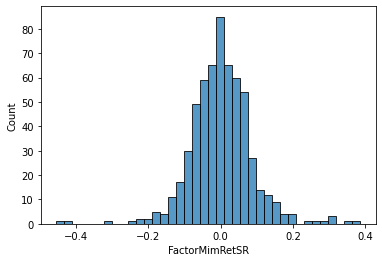

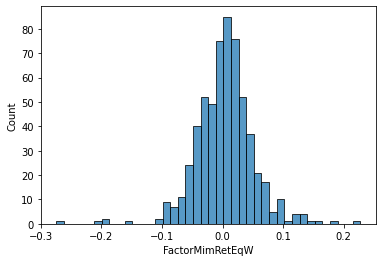

In [79]:
sns.histplot(returns['FactorMimRetSR'])
plt.show()
sns.histplot(returns['FactorMimRetEqW'])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         FactorMimRetSR   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     119.1
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           2.25e-25
Time:                        20:06:30   Log-Likelihood:                 673.60
No. Observations:                 590   AIC:                            -1343.
Df Residuals:                     588   BIC:                            -1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0011      0.003     -0.352      0.725      -0.007       0.005
FactorMimRetEqW     0.7304      0.067     10.913      0.000       0.599       0.862
==============================================================================
Omnibus:                       61.244   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.934
Skew:                           0.005   Prob(JB):                     1.94e-88
Kurtosis:                       7.054   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

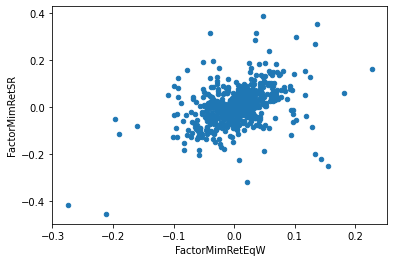

In [80]:
returns[['FactorMimRetSR', 'FactorMimRetEqW']].plot.scatter(x='FactorMimRetEqW',y='FactorMimRetSR')
sm.OLS(returns['FactorMimRetSR'],sm.add_constant(returns['FactorMimRetEqW'])).fit().summary()

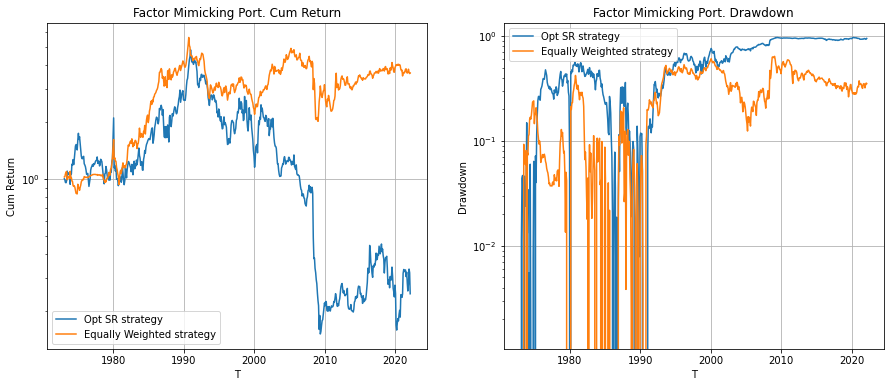

In [81]:
fig, ax = plt.subplots(1, 2, figsize = (15,  6))
cum_ret = metrics.get_cumulativeReturn()

returns[['CumRetSR', 'CumRetEqW']] = cum_ret
returns[['DD_SR', 'DD_EqW']] = metrics.get_drawdown()

ax[0].set_yscale('log')

ax[0].plot(returns['Date'],returns['CumRetSR'], label = 'Opt SR strategy')
ax[0].plot(returns['Date'],returns['CumRetEqW'], label = 'Equally Weighted strategy')

ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('Cum Return')
ax[0].set_xlabel('T')

ax[1].set_yscale('log')
ax[1].plot(returns['Date'],returns['DD_SR'], label = 'Opt SR strategy')
ax[1].plot(returns['Date'],returns['DD_EqW'], label = 'Equally Weighted strategy')

ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('T')


ax[0].set_title('Factor Mimicking Port. Cum Return')
ax[1].set_title('Factor Mimicking Port. Drawdown')

plt.show()

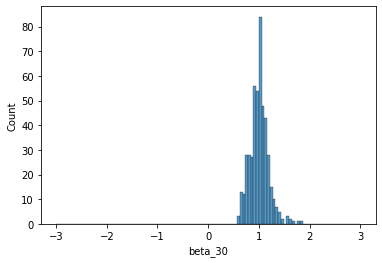

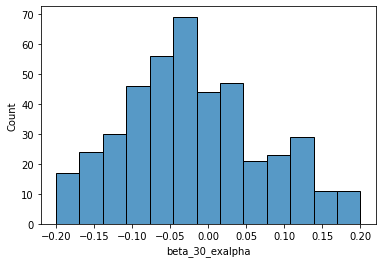

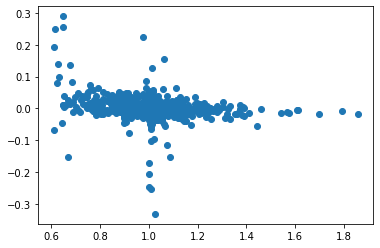

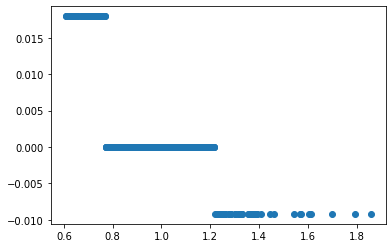

In [82]:
sns.histplot(investableStocks['beta_30'],binrange=(-3,3))
plt.show()
sns.histplot(investableStocks['beta_30_exalpha'],binrange=(-.2,.2))
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['scaled_w'])
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['wEqScaled'])
plt.show()

# Performance metrics investor portfolio


In [83]:
#Performance metrics (in sample)
inSample = returnsInvestor[returnsInvestor['Date'] < '2000-01-01']
rf = inSample['RF']
market = inSample['Mkt-RF']
rets = inSample.loc[:, ['Benchmark', 'InvestorPortfolio']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/InvestorInSample.csv')

In [84]:
#Performance metrics (out of sample)
outSample = returnsInvestor[returnsInvestor['Date'] >= '2000-01-01']
rf = outSample['RF']
market = outSample['Mkt-RF']
rets = outSample.loc[:, ['Benchmark', 'InvestorPortfolio']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/InvestorOutSample.csv')

In [85]:
rf = returnsInvestor['RF']
market = returnsInvestor['Mkt-RF']
rets = returnsInvestor.loc[:, ['Benchmark', 'InvestorPortfolio']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = False).to_csv('./data/InvestorAll.csv')

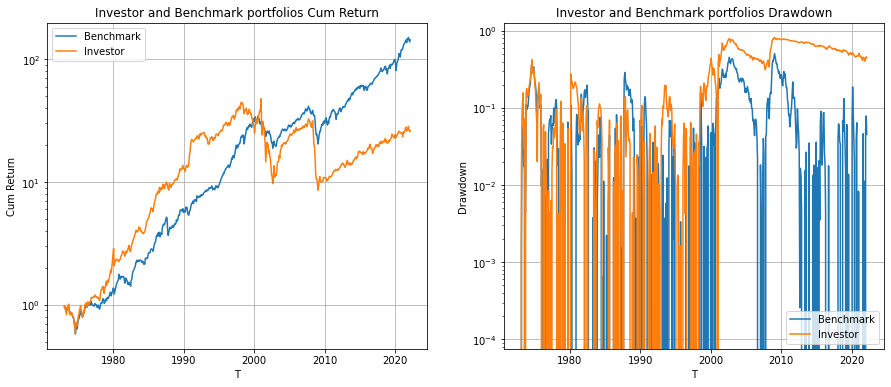

In [86]:
fig, ax = plt.subplots(1, 2, figsize = (15,  6))
cum_ret = metrics.get_cumulativeReturn()

returnsInvestor[['CumRetBenchMark', 'CumRetInvestor']] = cum_ret
returnsInvestor[['DD_BM', 'DD_Inv']] = metrics.get_drawdown()

ax[0].set_yscale('log')

ax[0].plot(returnsInvestor['Date'],returnsInvestor['CumRetBenchMark'], label = 'Benchmark')
ax[0].plot(returnsInvestor['Date'],returnsInvestor['CumRetInvestor'], label = 'Investor')

ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('Cum Return')
ax[0].set_xlabel('T')

ax[1].set_yscale('log')
ax[1].plot(returnsInvestor['Date'],returnsInvestor['DD_BM'], label = 'Benchmark')
ax[1].plot(returnsInvestor['Date'],returnsInvestor['DD_Inv'], label = 'Investor')

ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('T')

ax[0].set_title('Investor and Benchmark portfolios Cum Return')
ax[1].set_title('Investor and Benchmark portfolios Drawdown')
plt.show()